# Setup
Various options for the solution analysis.


In [1]:
''' DATA '''
# path to projects JSON file
PROJECTS_JSON_PATH = 'data/projects.json'

# use test data instead (default: False)
do_test = False

''' OUTPUT '''
# print individual project start/end (default: False)
do_print = False

# plot Gantt Chart (default: True)
do_plot = True

# Package Installation

The [PuLP](https://coin-or.github.io/pulp/index.html) package is used to solve the Mixed Integer Linear Programming problem.

In [2]:
try:
    import pulp
    print("pulp package already installed.")

except ModuleNotFoundError:
    print("Installing pulp package...")
    !pip install pulp

Installing pulp package...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 3.7 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.3.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


# Import Project Data

In [3]:
# import from json file
import json
with open(PROJECTS_JSON_PATH, "r") as file:
    projects = json.load(file)

# use test data if test option is enabled
if do_test:
  projects = {
      '1': {"name": "Wind Farm", "duration": 1.0, "dependencies": []},
      '2': {"name": "H2", "duration": 1.0, "dependencies": []},
      '3': {"name": "Solar Farm", "duration": 1.0, "dependencies": [2]},
      '4': {"name": "Solar Farm", "duration": 2.0, "dependencies": [1, 3]},
      '5': {"name": "H2 Plant", "duration": 3.0, "dependencies": [1, 2, 6]},
      '6': {"name": "Wind Farm", "duration": 1.0, "dependencies": [1]},
  }

In [4]:
import pulp as pl

# LP variable representing the start of a project
start_times = {}

# mapping from LP variable to its duration (useful later)
var_duration = dict()

# create LP variables
for project_id, project_data in projects.items():
    project_id = int(project_id)
    name = project_data["name"].replace(" ", "_")
    var_name = f"#{project_id}-{name}-Start"
    start_var = pl.LpVariable(var_name, lowBound=0, cat=pl.LpInteger)
    start_times[project_id] = start_var
    var_duration[start_var] = project_data["duration"]

# Define + Solve Problem

In [5]:
problem = pl.LpProblem("Project Schedule", pl.LpMinimize)

# objective function
problem += sum(start_times.values())

/Users/chirayu/opt/anaconda3/lib/python3.9/site-packages/pulp/pulp.py:1298: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


In [6]:
# constraints (project dependencies)
for project_id, project_data in projects.items():
    for dependency in project_data["dependencies"]:
      problem += start_times[int(project_id)] >= start_times[int(dependency)] + projects[str(dependency)]["duration"]


In [ ]:
status = problem.solve()

if pl.LpStatus[status] == "Optimal":
    print("Optimal Solution found!")

    end_times = [x.varValue + var_duration[x] for x in problem.variables()]
    plan_duration = max(end_times)
    print("Plan Duration:", plan_duration)

    if do_print:
      print("Project Schedule:")
      for project_id, project_data in projects.items():
          start_time = pl.value(start_times[int(project_id)])
          end_time = start_time + project_data["duration"]
          name = project_data["name"].replace(" ", "_")
          print(f"{name}: Start - {start_time:.2f}, End - {end_time:.2f}")
else:
  print(f"Error: {pl.LpStatus[status]}. Status {status}")


# Plot

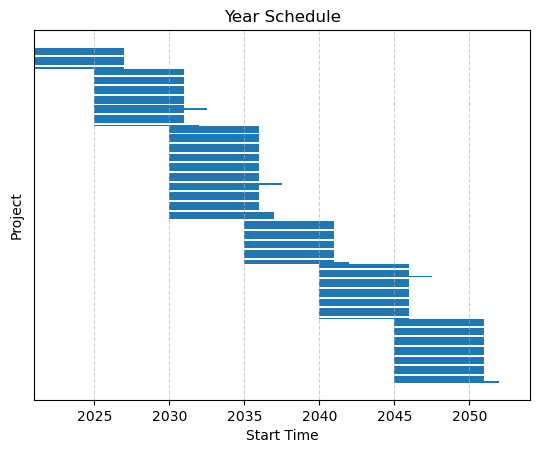

In [8]:
import matplotlib.pyplot as plt

# TODO: aggregate projects together (ex: all solar farms pre-FID)
# TODO: plot cumulative capacity deployed (compare model deployed capacity over time)

if do_plot:
  project_names = [project_data["name"] + f" (id {project_id})" for project_id, project_data in projects.items()]
  project_start_times = [pl.value(start_times[int(project_id)]) for project_id, project_data in projects.items()]
  durations = [project_data["duration"] for project_id, project_data in projects.items()]

  # plot starting at 2021
  adjusted_start_times = [start_time + 2021 for start_time in project_start_times]

  plt.barh(project_names, durations, left=adjusted_start_times)
  plt.xlabel("Start Time")
  plt.ylabel("Project")
  plt.title("Year Schedule")

  # remove individual project labels (for now)
  plt.yticks([])

  plt.gca().invert_yaxis()  # Invert y-axis to display projects from top to bottom
  plt.grid(axis="x", linestyle="--", alpha=0.6)
  plt.show()

else:
  print("Plot disabled.")